In [1]:
# My created .py files for modularization
import env
import os
import wrangle as w
# Ignore Warning
import warnings
warnings.filterwarnings("ignore")
# Array and Dataframes
import numpy as np
import pandas as pd
# Imputer
from sklearn.impute import SimpleImputer
# Evaluation: Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Evaluation: Statistical Analysis
from scipy import stats
# Modeling: Scaling
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler, RobustScaler
# Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as knn
# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
zillow = w.zillow()

File exists pulling from system.


In [3]:
zillow.sample(5)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,county
1275946,2.0,2.0,1600.0,374366.0,1978.0,4537.80,6037.0
264622,3.0,3.0,2087.0,631883.0,1956.0,7783.62,6037.0
283998,2.0,1.0,912.0,32460.0,1919.0,446.85,6037.0
1358518,4.0,3.0,2096.0,135977.0,1954.0,1853.34,6037.0
139307,4.0,4.5,4366.0,2001471.0,1998.0,20692.34,6059.0


In [4]:
# Splitting data for modeling
train, validate, test = w.splitter(zillow,target='taxamount')


Dataframe: (2140235, 7) 100%
Train: (1369750, 7) | ~60%
Validate: (342438, 7) | ~20%
Test: (428047, 7) | ~20%


In [5]:
scaleCols = train.loc[:,zillow.columns != ('taxamount','county')]

In [6]:
# preview distributions -- cant really use because the size of dataset and outliers
### how to see these distributions easier ###
# for col in scaleCols.columns:
#     plt.rcParams["figure.figsize"] = [7.00, 3.50]
#     plt.rcParams["figure.autolayout"] = True
#     sns.histplot(data=zillow, x=col)
#     plt.title(col)
#     plt.show()

In [7]:
# assigning x and y
x_train = train.loc[:,zillow.columns != ('taxamount','county')]
y_train = train['taxamount']

x_validate = validate.loc[:,zillow.columns != ('taxamount','county')]
y_validate = validate['taxamount']

x_test = test.loc[:,zillow.columns != ('taxamount','county')]
y_test = test['taxamount']

In [10]:
# train
train_scaled_MinMax, train_scaled_S, train_scaled_R, validatevalidate_scaled_MinMax, validate_scaled_S, validate_scaled_R = w.ScaledTrain(x_train, x_validate)

In [11]:
# model object
model = knn()

In [21]:
# Cant go into modeling with continious labe for categorical model
#model.fit(train_scaled_MinMax, y_train)

In [17]:
scaler = MinMaxScaler()

scaler.fit_transform(x_train)

array([[0.22222222, 0.0625    , 0.00192426, ..., 0.78139535, 0.00555149,
        0.2972973 ],
       [0.16666667, 0.0625    , 0.00177729, ..., 0.68837209, 0.00437589,
        0.        ],
       [0.22222222, 0.09375   , 0.00240821, ..., 0.82325581, 0.00502792,
        1.        ],
       ...,
       [0.        , 0.03125   , 0.00130068, ..., 0.57674419, 0.0033095 ,
        0.        ],
       [0.22222222, 0.03125   , 0.00117051, ..., 0.72093023, 0.001369  ,
        0.        ],
       [0.11111111, 0.0625    , 0.001223  , ..., 0.78139535, 0.00526037,
        0.2972973 ]])

In [19]:
back_to_x_train = scaler.inverse_transform(train_scaled_MinMax)
back_to_x_train

array([[4.00000e+00, 2.00000e+00, 1.83400e+03, ..., 1.96900e+03,
        5.99836e+03, 6.05900e+03],
       [3.00000e+00, 2.00000e+00, 1.69400e+03, ..., 1.94900e+03,
        4.73096e+03, 6.03700e+03],
       [4.00000e+00, 3.00000e+00, 2.29500e+03, ..., 1.97800e+03,
        5.43390e+03, 6.11100e+03],
       ...,
       [0.00000e+00, 1.00000e+00, 1.24000e+03, ..., 1.92500e+03,
        3.58129e+03, 6.03700e+03],
       [4.00000e+00, 1.00000e+00, 1.11600e+03, ..., 1.95600e+03,
        1.48926e+03, 6.03700e+03],
       [2.00000e+00, 2.00000e+00, 1.16600e+03, ..., 1.96900e+03,
        5.68450e+03, 6.05900e+03]])

<Axes: ylabel='Count'>

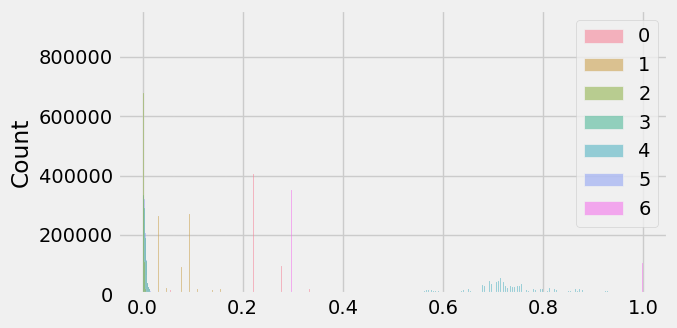

In [ ]:
sns.histplot(data=train_scaled_MinMax)

In [ ]:
sns.histplot(data=train,x=scaleCols)

KeyboardInterrupt: 